In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import regex as re

from thesis.plotting_utils import get_figsize, thesis_figure_style

In [2]:
DATA_DIR = Path("../data")
FIGURE_DIR = Path("../figures")
COLUMN_NAME_PATTERN = (
    r"^(?:truthful_openai_minimal_(?P<run_id>\d) - (?:eval|train)/loss|Step)$"
)

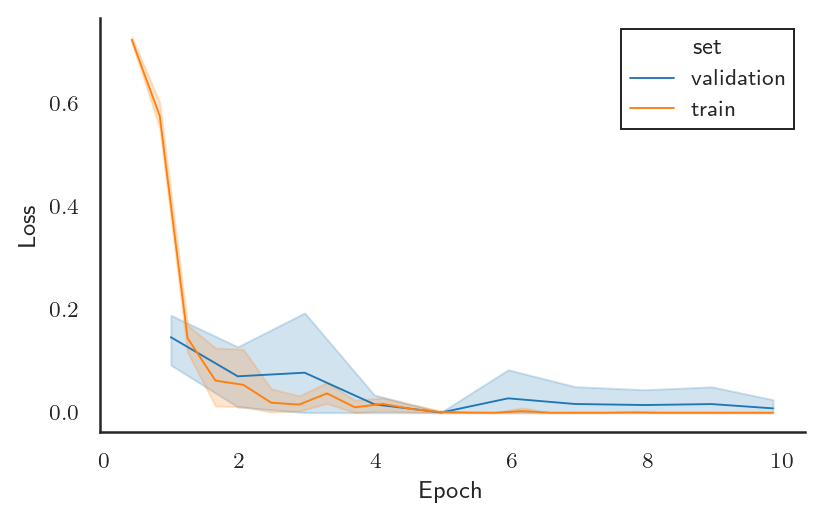

In [3]:
def get_column_name(name: str) -> str:
    m = re.match(COLUMN_NAME_PATTERN, name)
    if m is None:
        return name.lower()

    column_name = m.groupdict(default=name.lower())["run_id"]

    return column_name


def sanitize_loss_data(data: pd.DataFrame) -> pd.DataFrame:
    sanizized_data = (
        data.filter(regex=COLUMN_NAME_PATTERN)
        .rename(columns=get_column_name)
        .melt(id_vars=["step"], var_name="run_id", value_name="loss")
    )

    return sanizized_data


def load_single_loss_dataset(loss_dir: Path, set_: str) -> pd.DataFrame:
    set_name = set_
    if set_ == "eval":
        set_name = "validation"

    loss = (
        pd.read_csv(loss_dir / f"truthful_openai_minimal_{set_}_loss.csv")
        .pipe(sanitize_loss_data)
        .assign(set=set_name)
    )
    return loss


def load_global_steps(loss_dir: Path) -> pd.Series:
    global_step_col_name = "truthful_openai_minimal_0 - train/global_step"
    global_steps = (
        pd.read_csv(loss_dir / "steps_to_global.csv")
        .rename(columns={"Step": "step", global_step_col_name: "global_step"})
        .set_index("step")
        .loc[:, "global_step"]
    )

    return global_steps


def load_loss_data() -> pd.DataFrame:
    loss_data_dir = DATA_DIR / "classification" / "training"
    eval_loss = load_single_loss_dataset(loss_data_dir, "eval")
    train_loss = load_single_loss_dataset(loss_data_dir, "train")
    global_steps = load_global_steps(loss_data_dir)

    loss = (
        pd.concat([eval_loss, train_loss], ignore_index=True)
        .join(global_steps, on="step")
        .assign(epoch=lambda df: df.global_step * 0.041)
    )

    return loss


def plot_loss_data():
    loss = load_loss_data()

    with thesis_figure_style(sns_style_args={"style": "white"}):
        fig = plt.figure(figsize=get_figsize(fraction=0.8))
        ax = fig.gca()
        sns.lineplot(data=loss, x="epoch", y="loss", hue="set", ax=ax)
        sns.despine(ax=ax)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")

    fig_path = FIGURE_DIR / "training_loss_curves.pgf"
    fig.savefig(fig_path, backend="pgf")


plot_loss_data()